In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package
from osgeo import gdal
import pprint
import time

In [2]:
# Carregar os dados do grib da data especificada
data = "20190110"
ciclo = "00"
hora = 3
grib = gdal.Open("../grib/{}_{}/gfs.t00z.pgrb2.0p25.f{:03d}".format(data, ciclo, hora))

## Numero de Bandas / Layers

In [3]:
number_of_bands = grib.RasterCount
print(number_of_bands)

417


## Nome cada Layer

In [4]:
for i in range(1,number_of_bands+1):
    band = grib.GetRasterBand(i)
    metadata = band.GetMetadata()
    band_name = metadata['GRIB_COMMENT']
    band_description = band.GetDescription()
    print("{} : {} \t\t- {}".format(i,band_name,band_description))

1 : Visibility [m] 		- 0[-] SFC="Ground or water surface"
2 : u-component of wind [m/s] 		- 0[-] RESERVED(220) (Reserved Local use)
3 : v-component of wind [m/s] 		- 0[-] RESERVED(220) (Reserved Local use)
4 : (prodType 0, cat 2, subcat 224) [-] [-] 		- 0[-] RESERVED(220) (Reserved Local use)
5 : Wind speed (gust) [m/s] 		- 0[-] SFC="Ground or water surface"
6 : Geopotential height [gpm] 		- 100[Pa] ISBL="Isobaric surface"
7 : Temperature [C] 		- 100[Pa] ISBL="Isobaric surface"
8 : Relative humidity [%] 		- 100[Pa] ISBL="Isobaric surface"
9 : u-component of wind [m/s] 		- 100[Pa] ISBL="Isobaric surface"
10 : v-component of wind [m/s] 		- 100[Pa] ISBL="Isobaric surface"
11 : Ozone Mixing Ratio [kg/kg] 		- 100[Pa] ISBL="Isobaric surface"
12 : Geopotential height [gpm] 		- 200[Pa] ISBL="Isobaric surface"
13 : Temperature [C] 		- 200[Pa] ISBL="Isobaric surface"
14 : Relative humidity [%] 		- 200[Pa] ISBL="Isobaric surface"
15 : u-component of wind [m/s] 		- 200[Pa] ISBL="Isobaric surface"


## Limites do dataset

In [5]:
ulx, xres, xskew, uly, yskew, yres  = grib.GetGeoTransform()
lrx = ulx + (grib.RasterXSize * xres)
lry = uly + (grib.RasterYSize * yres)
print("{} {} {} {}".format(ulx, uly, lrx, lry))

-0.125 90.125 359.875 -90.125


In [6]:
grib.GetGeoTransform()

(-0.125, 0.25, 0.0, 90.125, 0.0, -0.25)

## Ler todos as maximas temperaturas

In [31]:
bandTemp = []
bandMeta = []
for i in range (3, 23,3):
        grib = gdal.Open("../grib/{}_{}/gfs.t00z.pgrb2.0p25.f{:03d}".format(data, ciclo, i))
        bandMeta.append(grib.GetRasterBand(286).GetMetadata())
        bandTemp.append(grib.GetRasterBand(286).ReadAsArray()[280:640,960:1360])
        print("hora: {}".format(i))

hora: 3
hora: 6
hora: 9
hora: 12
hora: 15
hora: 18
hora: 21


## Maximas

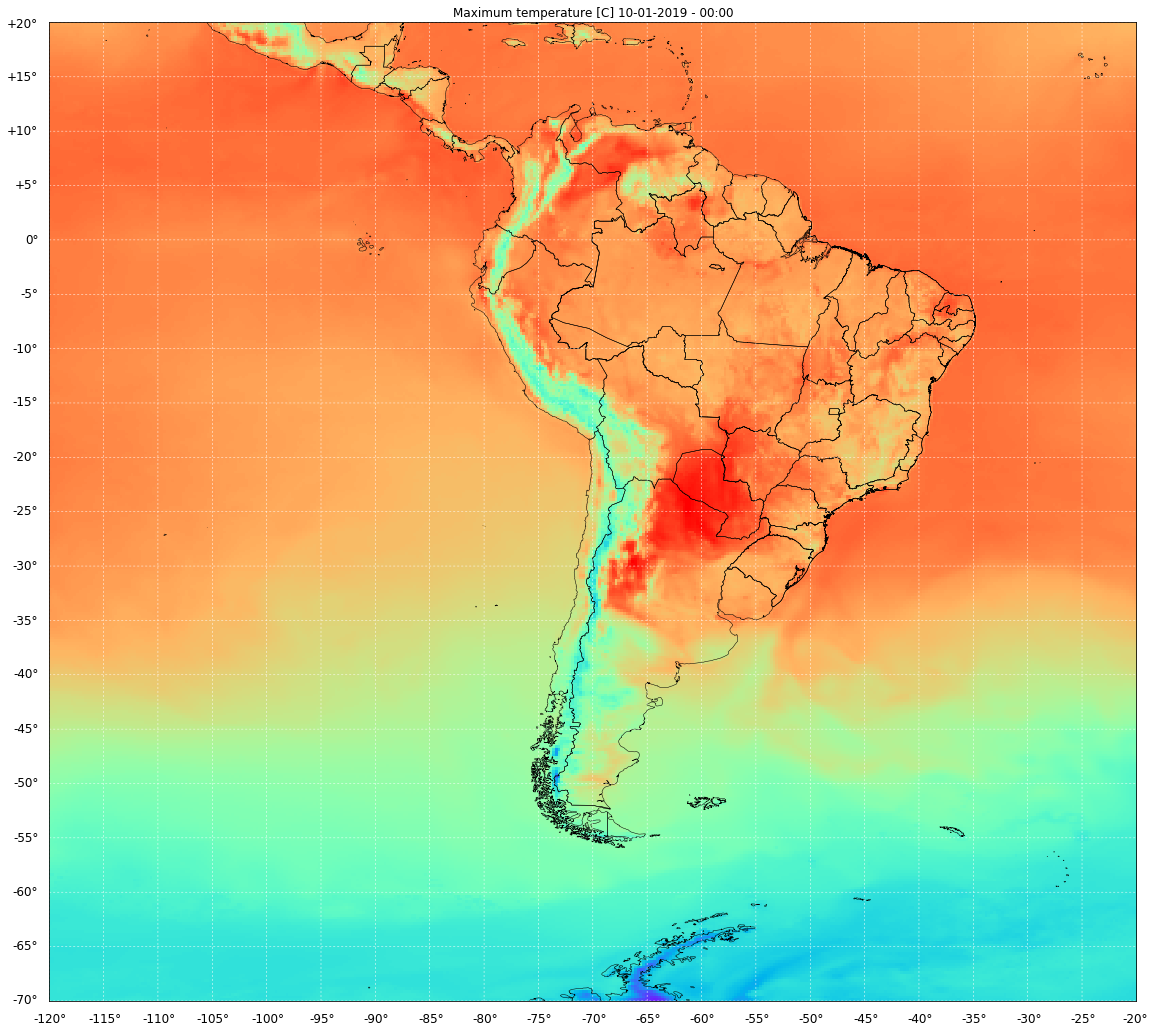

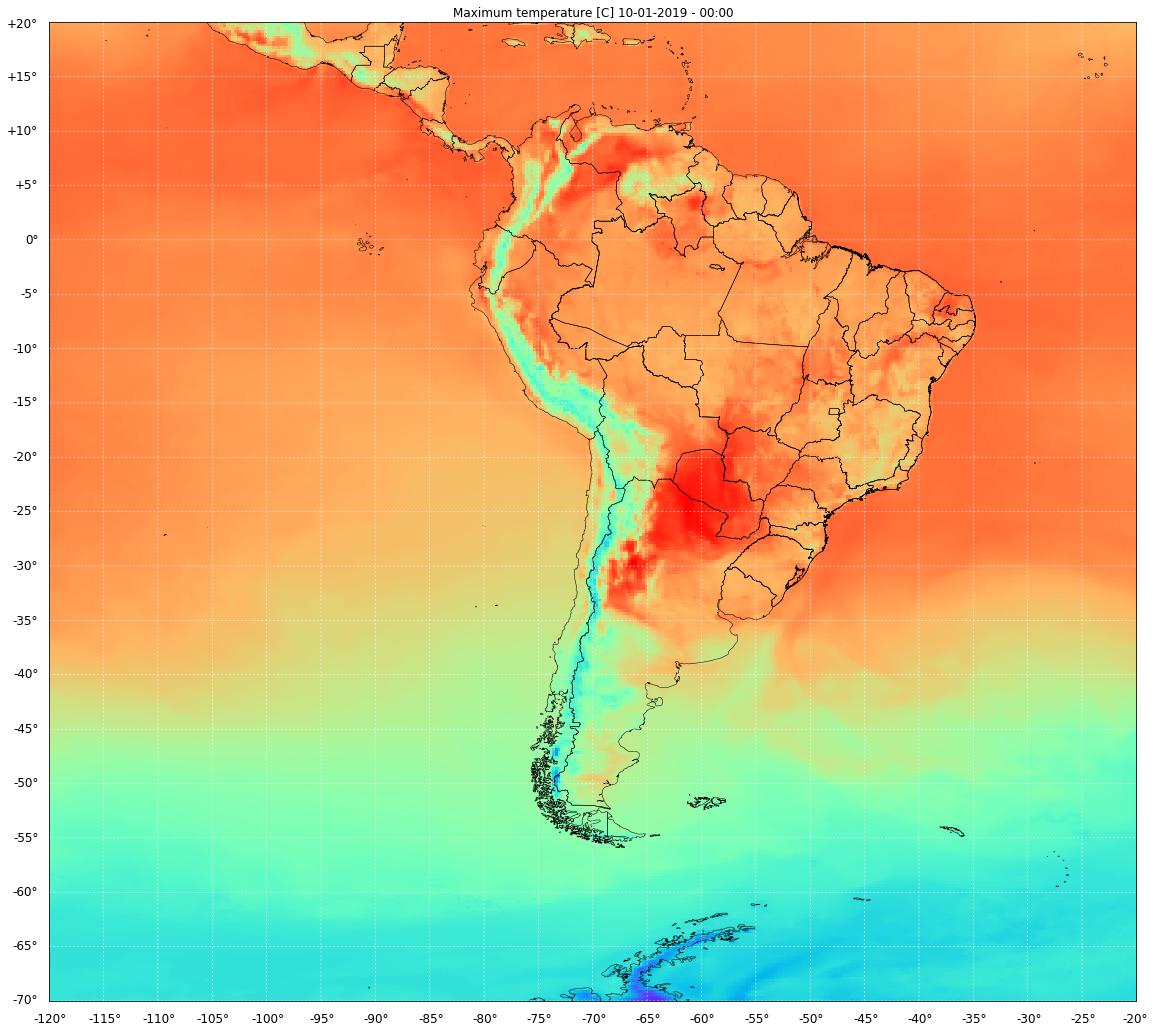

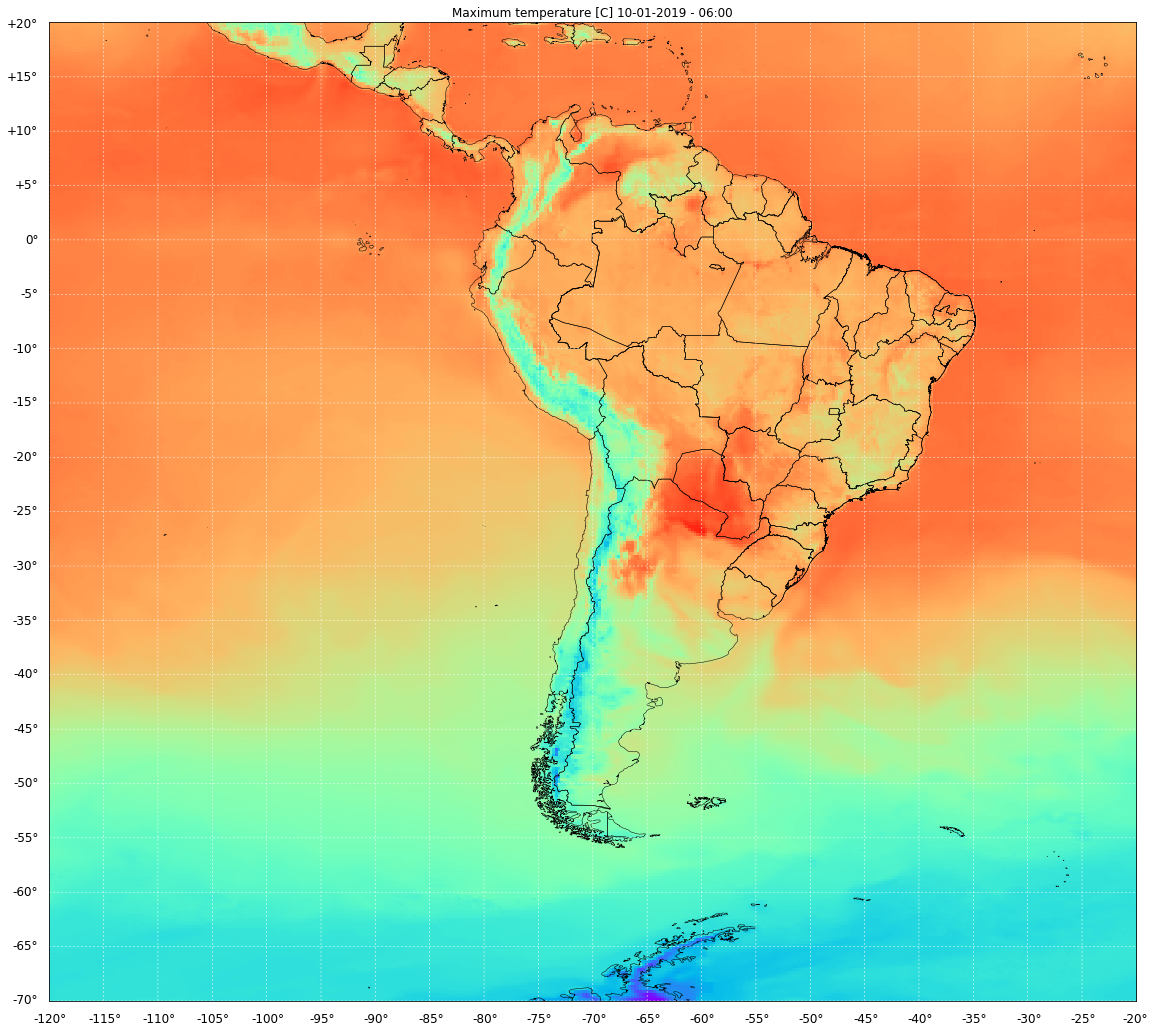

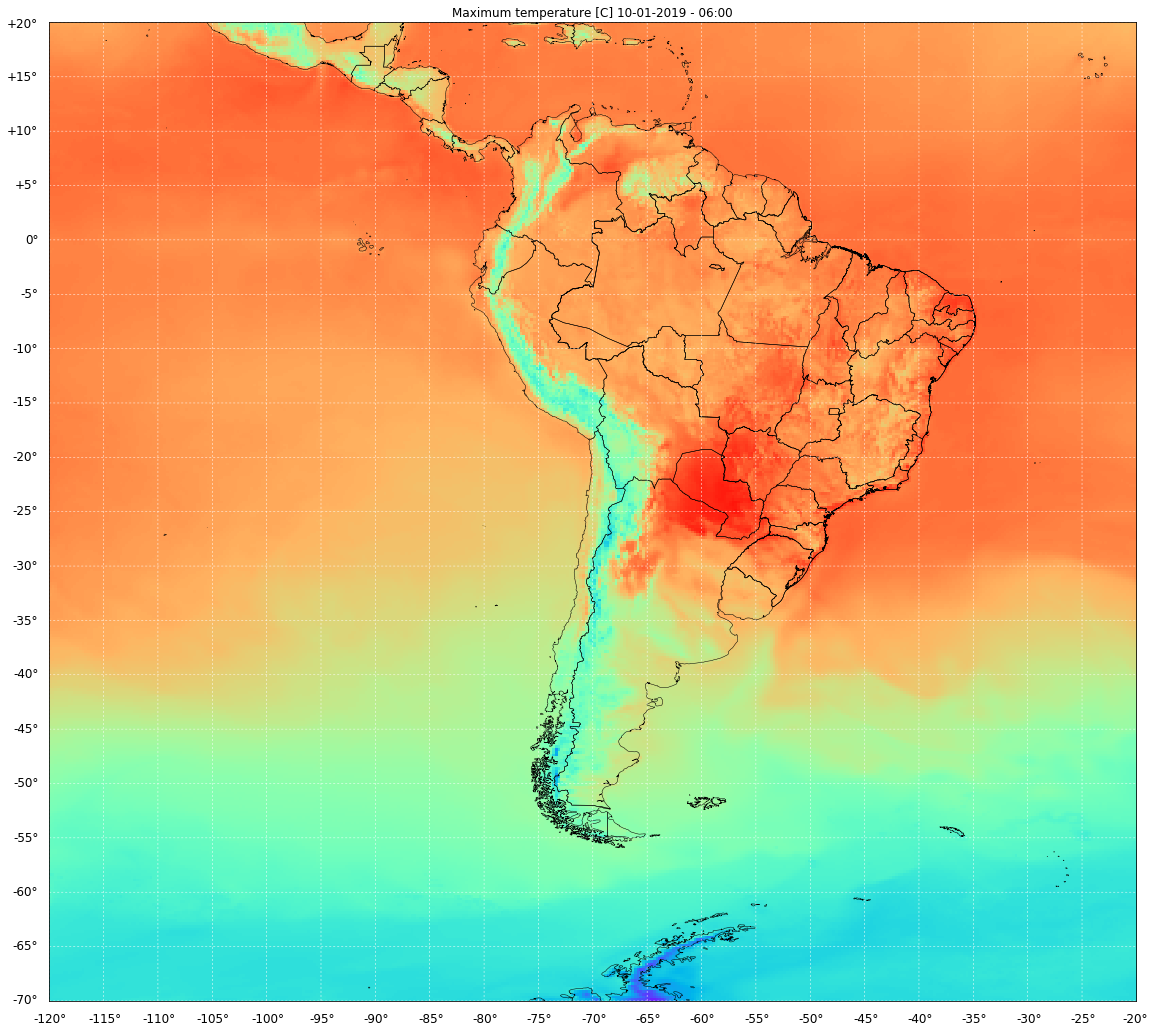

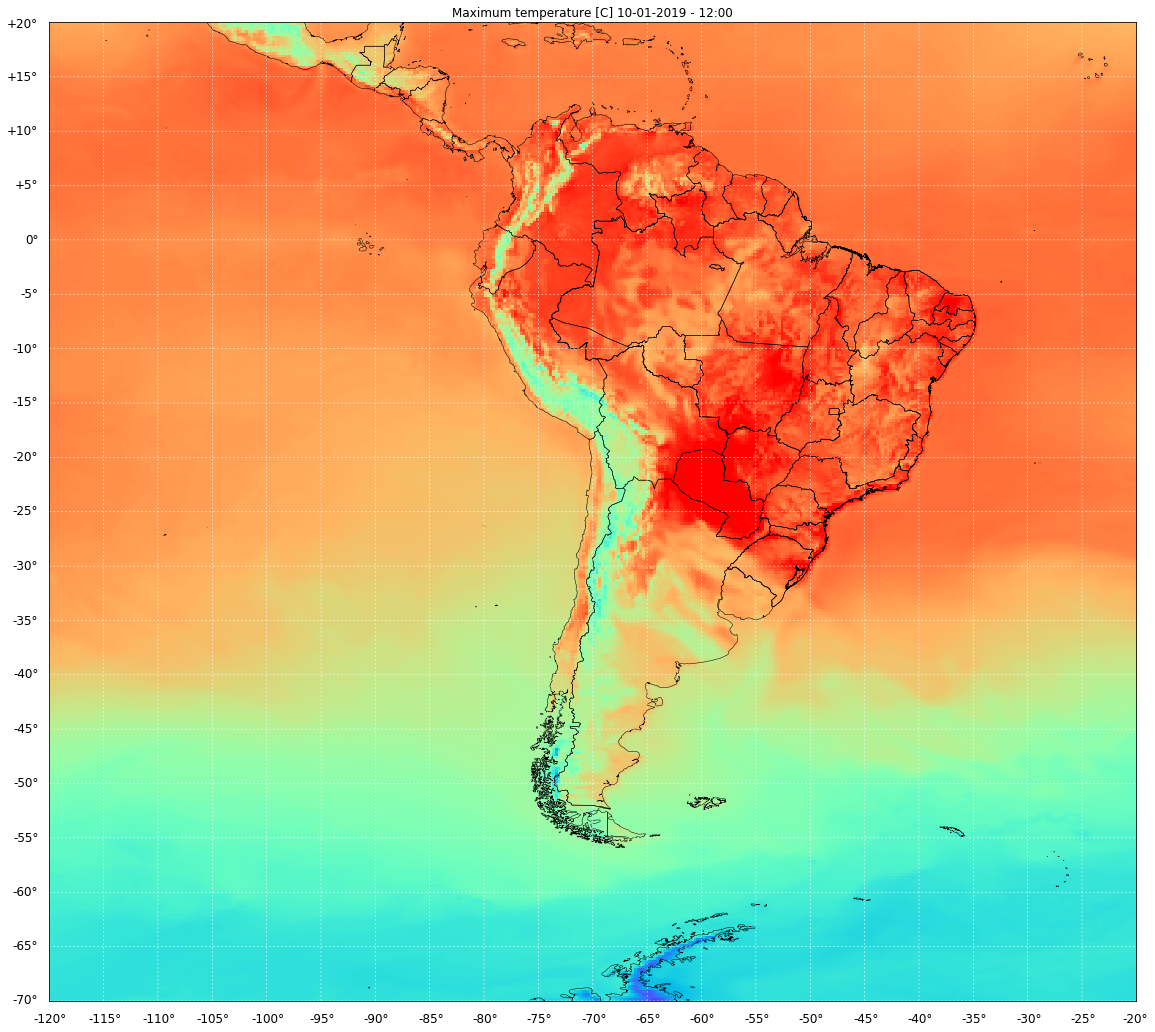

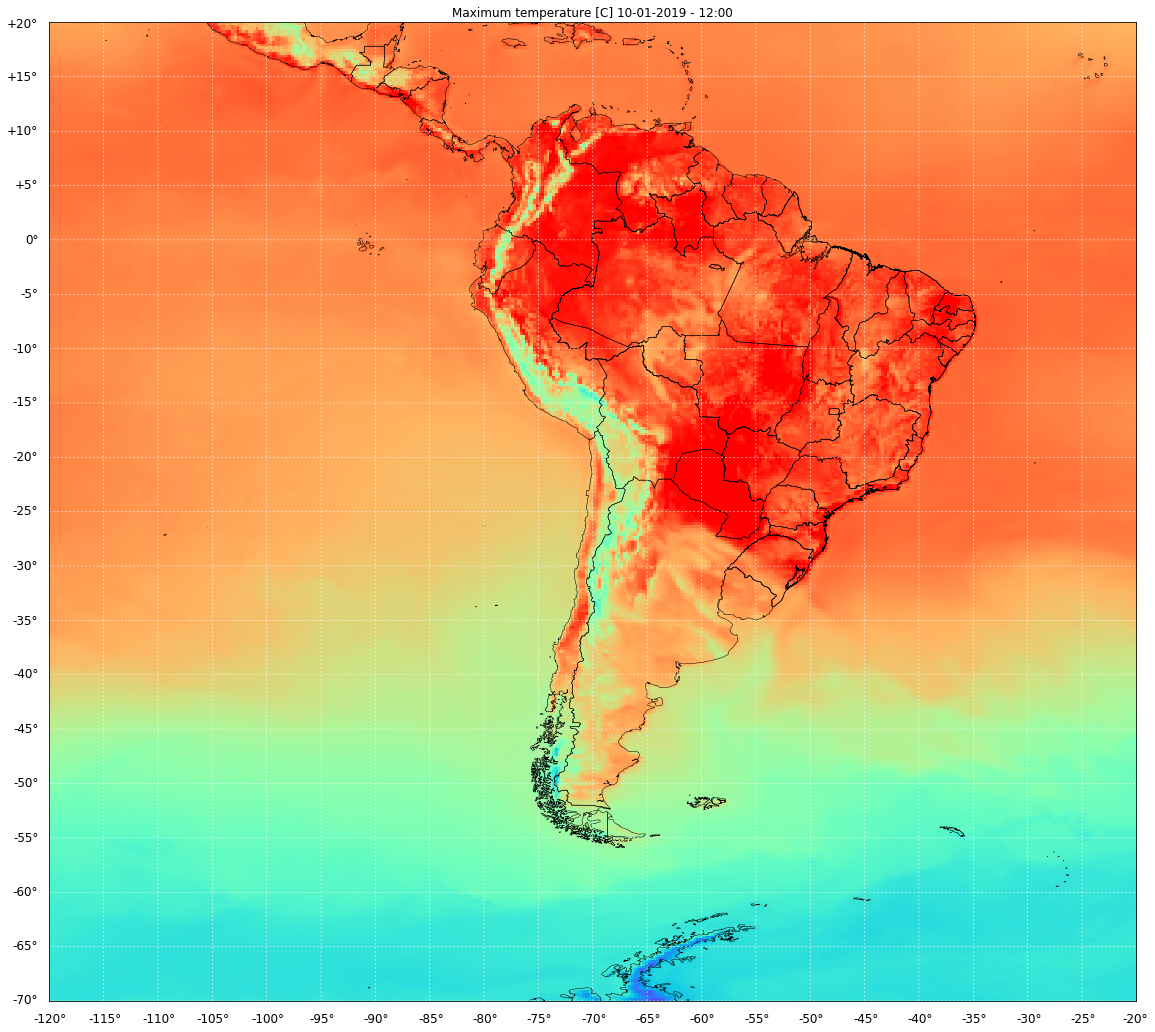

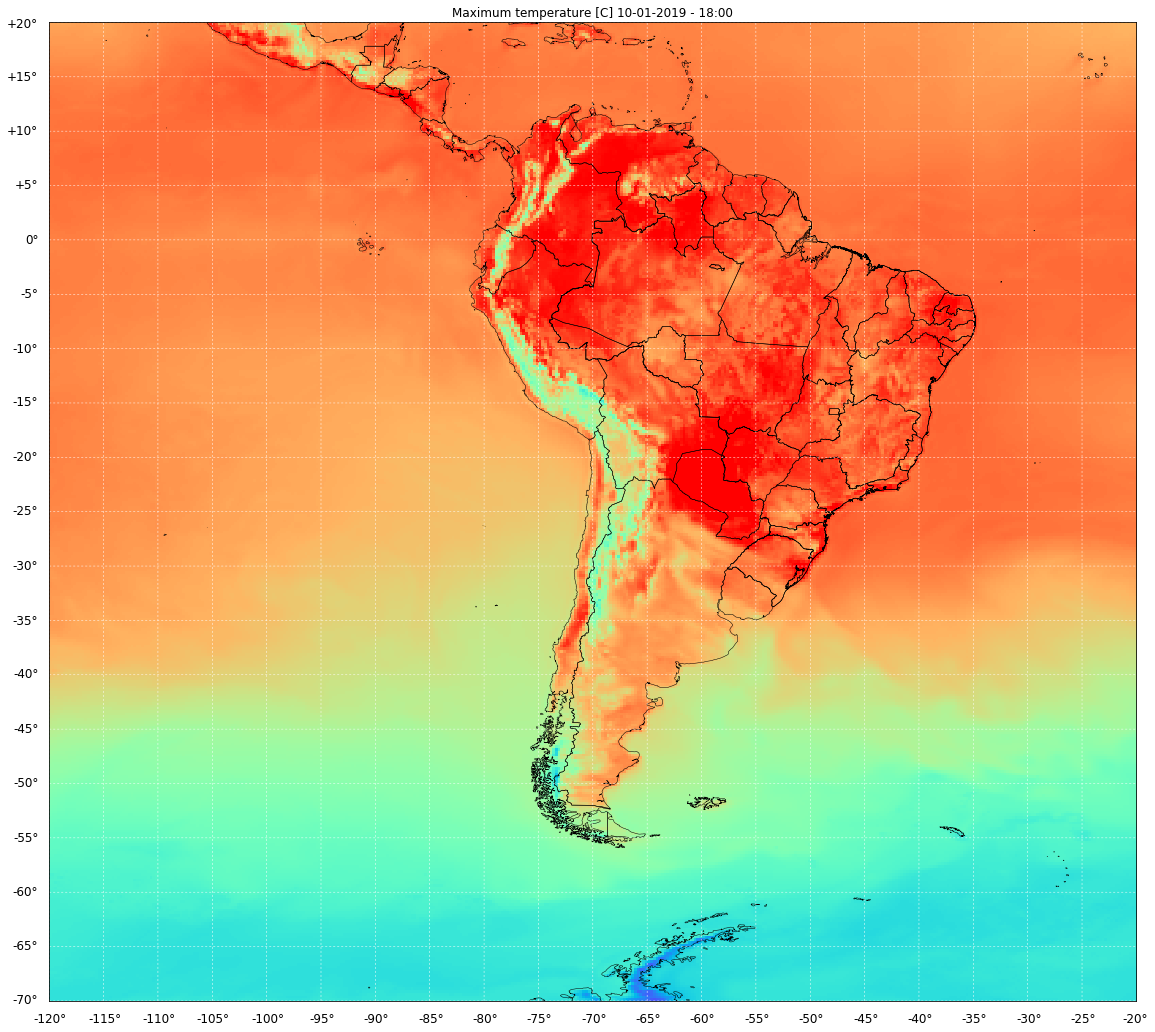

In [28]:
for i in range(0,7):
    plt.figure(figsize=(20,18))
    extent = [-120.0, -70, -20, 20.0]
    bmap = Basemap(llcrnrlon=extent[0], llcrnrlat=extent[1], urcrnrlon=extent[2], urcrnrlat=extent[3], epsg=4326)

    # Draw the countries and Brazilian states shapefiles
    bmap.readshapefile('..\\shape\\BRA_adm1','BRA_adm1',linewidth=0.50,color='black')
    bmap.readshapefile('..\\shape\\ne_10m_admin_0_countries','ne_10m_admin_0_countries',linewidth=0.50,color='black')

    #bmap.drawcountries()
    #bmap.drawcoastlines()

    # Draw parallels and meridians
    bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.5, dashes=[4, 4], color='white', labels=[True,False,False,True], fmt='%g', labelstyle="+/-", size=12)
    bmap.drawmeridians(np.arange(0.0, 360.0, 5.0), linewidth=0.5, dashes=[4, 4], color='white', labels=[True,False,False,True], fmt='%g', labelstyle="+/-", size=12)

    # Plot the model information
    
    #image = bmap.imshow(i, origin='upper', cmap='rainbow', aspect='equal', interpolation='bicubic', vmin = -20, vmax = 35)
    
    horaUTC= int(bandMeta[i]['GRIB_REF_TIME'].split("sec UTC")[0])
    forecast = int(bandMeta[i]['GRIB_FORECAST_SECONDS'].split("sec")[0])
    desc = bandMeta[i]['GRIB_COMMENT']
    
    plt.title("{} {}".format(desc, time.strftime('%d-%m-%Y - %H:%M', time.gmtime(horaUTC+forecast))))
    image = bmap.imshow(bandTemp[i], origin='upper', cmap='rainbow', aspect='equal', vmin = -20, vmax = 35)
    plt.savefig("..\\max\\{}_max{:02d}.jpg".format(data,i))